### Smooth NDVI time series using entire dataset and calculate SOS
Uses the full time series to despike re-smooth NDVI, then calculates the 
start of season (SOS) for each plot and year using the NDVI time series

#### Imports

In [1]:
import numpy as np
import os
import re
import pandas as pd
from datetime import datetime, timedelta
import time
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

#### Input/Ouput paths

In [24]:
# input path
inPATH_ndvi = './data/extractions/carm3_ndvi_2014_2023.csv'

# output paths
outPATH_ndvi = re.sub('.csv', '_cln.csv', os.path.join('./data',
                                                       os.path.basename(inPATH_ndvi)))
outPATH_sos = './data/carm3_sos_2014_2023.csv'

#### Helper functions

In [25]:
def full_smooth_ndvi(ts, dates):
    ndvi_min = ts[(dates.dt.month < 3) | (dates.dt.month > 10)].quantile(0.05)
    ts_ds = pd.Series(
        despike_ts(ts.values, dat_thresh=0.025, days_thresh=61)).interpolate(limit=None)
    ts_smooth = pd.Series(double_savgol(ts_ds.values, window2=91), index=ts.index)
    #ts_smooth = pd.Series(savgol_filter(ts_ds, 91, 3), index=ts.index)
    return ts_smooth

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# explore creating SOS
def calc_sos(ndvi_ts):
    ndvi_thresh1 = np.nanpercentile(ndvi_ts[91:201], 40.0)
    date_thresh1 = next(x for x in np.where(ndvi_ts > ndvi_thresh1)[0] if x > 30)
    dndvi_ts = np.ones_like(ndvi_ts) * np.nan
    dndvi_ts[25:] = running_mean(np.diff(ndvi_ts), 25)
    dndvi_thresh2 = np.nanpercentile(dndvi_ts[:date_thresh1], 35.0)
    try:
        sos = np.where(dndvi_ts[:date_thresh1] < dndvi_thresh2)[0][-1]
    except IndexError:
        sos = np.nan
    return sos

def weighted_ndvi(ndvi_smooth1, ndvi_smooth2, sos):
    weights1 = np.ones_like(ndvi_smooth1)
    peak = np.argmax(ndvi_smooth1[120:300]) + 120
    weights1[:sos] = 0
    weights1[sos:peak] = np.linspace(0, 1, peak-sos)**4
    weights1[peak:] = np.linspace(1, 0, len(ndvi_smooth1) - peak)**4
    weights2 = 1.0 - weights1
    ndvi_wtd = np.average(np.array([ndvi_smooth1, ndvi_smooth2]), axis=0, weights=np.array([weights1, weights2]))
    return pd.Series(ndvi_wtd, index=ndvi_smooth1.index)
    

#### Prep data

In [26]:
# load the dataset
df_ndvi = pd.read_csv(inPATH_ndvi, parse_dates=[0])

In [27]:
df_ndvi['Year'] = df_ndvi['Date'].dt.year

#### Run secondary smoothing and calculate SOS

In [28]:
# run secondary smoothing on full time series
ndvi_ts_smooth = df_ndvi.groupby('Id').apply(lambda x: full_smooth_ndvi(x['NDVI'], x['Date']))
df_ndvi['NDVI_smooth2'] = ndvi_ts_smooth.droplevel(list(np.arange(ndvi_ts_smooth.index.nlevels-1)))

In [31]:
# calculate start of season as DOY for each plot and year
df_sos = df_ndvi.groupby([df_ndvi['Date'].dt.year, 
                              'Id'])['NDVI_smooth2'].apply(
    lambda x: calc_sos(x)).reset_index().rename(columns={'NDVI_smooth2': 'SOS_doy',
                                                         'Date': 'Year'})
# get as date
df_sos['SOS_date'] = df_sos.apply(lambda x: datetime(x['Year'], 1, 1) + timedelta(days=x['SOS_doy']), axis=1)

# merge with NDVI for plotting
df_sos = pd.merge(df_sos, df_ndvi[['Date', 'Id', 'NDVI_smooth2']], 
         left_on=['SOS_date', 'Id'],
         right_on=['Date', 'Id'], how='left')

In [32]:
df_ndvi#['Id'].unique()

,Date,Id,NDVI,NDVI_smooth,Year,NDVI_smooth2
0,2014-01-01,12C,NaN,0.187145,2014,0.181241
1,2014-01-02,12C,NaN,0.186701,2014,0.182789
2,2014-01-03,12C,NaN,0.186244,2014,0.184247
3,2014-01-04,12C,NaN,0.185762,2014,0.185617
4,2014-01-05,12C,NaN,0.185246,2014,0.186903
...,...,...,...,...,...,...
193551,2023-12-27,WeatherStation,NaN,0.258902,2023,0.259020
193552,2023-12-28,WeatherStation,NaN,0.256688,2023,0.257592
193553,2023-12-29,WeatherStation,0.25528,0.253938,2023,0.256074
193554,2023-12-30,WeatherStation,NaN,0.249644,2023,0.254463


<AxesSubplot:xlabel='SOS_date', ylabel='NDVI_smooth2'>

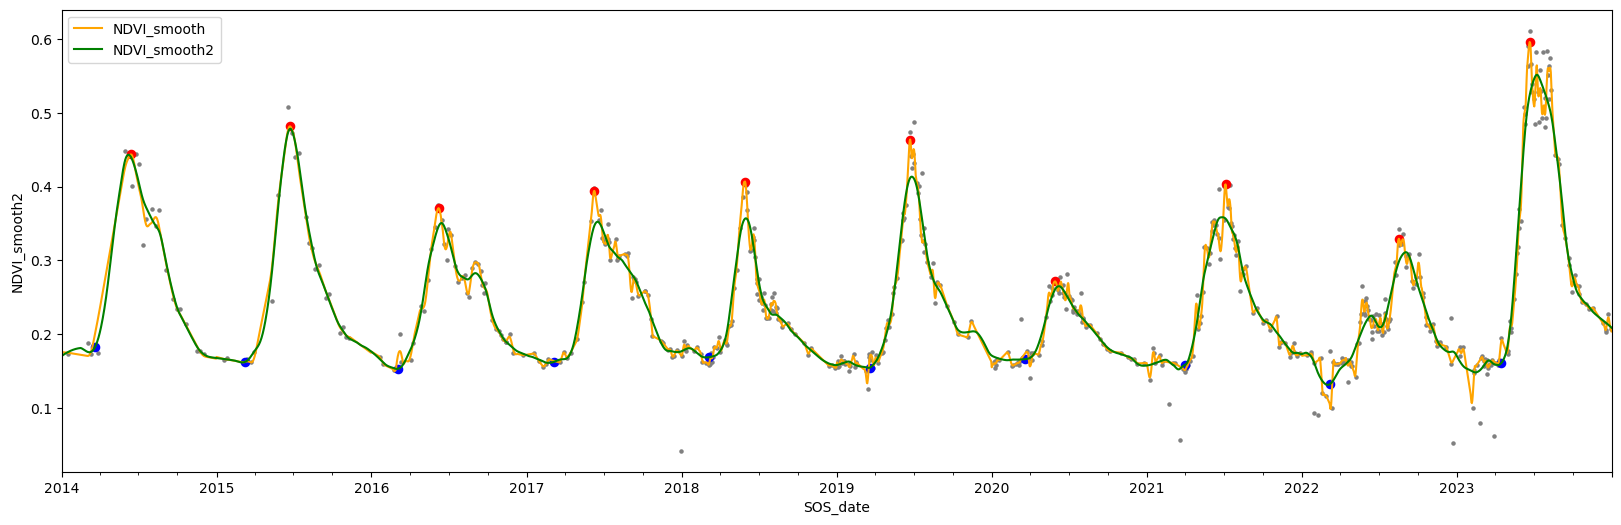

In [33]:
# plot updated smooth with start of season (blue) and peak of season (red)
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = 'Northeast'
ndvi_peak_vals = df_ndvi[df_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['NDVI_smooth'].iloc[np.argmax(x['NDVI_smooth'])])
ndvi_peak_dates = df_ndvi[df_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['Date'].iloc[np.argmax(x['NDVI_smooth'])])
df_ndvi[df_ndvi['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=ax1, c='grey', s=5)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth2', c='green', ax=ax1)
ax1.scatter(ndvi_peak_dates.values, ndvi_peak_vals.values, c='red', s=35)
df_sos[df_sos['Id'] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth2',  ax=ax1, c='blue', s=35)

In [34]:
# get average from two smooths, weighted by distance to SOS and peak NDVI 
ndvi_smooth_avg = df_ndvi.groupby(['Year', 'Id']).apply(lambda x: weighted_ndvi(x['NDVI_smooth'], 
                                                                  x['NDVI_smooth2'],
                                                                  df_sos[(df_sos['Year'] == x.name[0]) & 
                                                                         (df_sos['Id'] == x.name[1])]['SOS_doy'].values[0]))
df_ndvi['NDVI_smooth_avg'] = ndvi_smooth_avg.droplevel(list(np.arange(ndvi_smooth_avg.index.nlevels-1)))

<AxesSubplot:xlabel='Date', ylabel='NDVI_smooth2'>

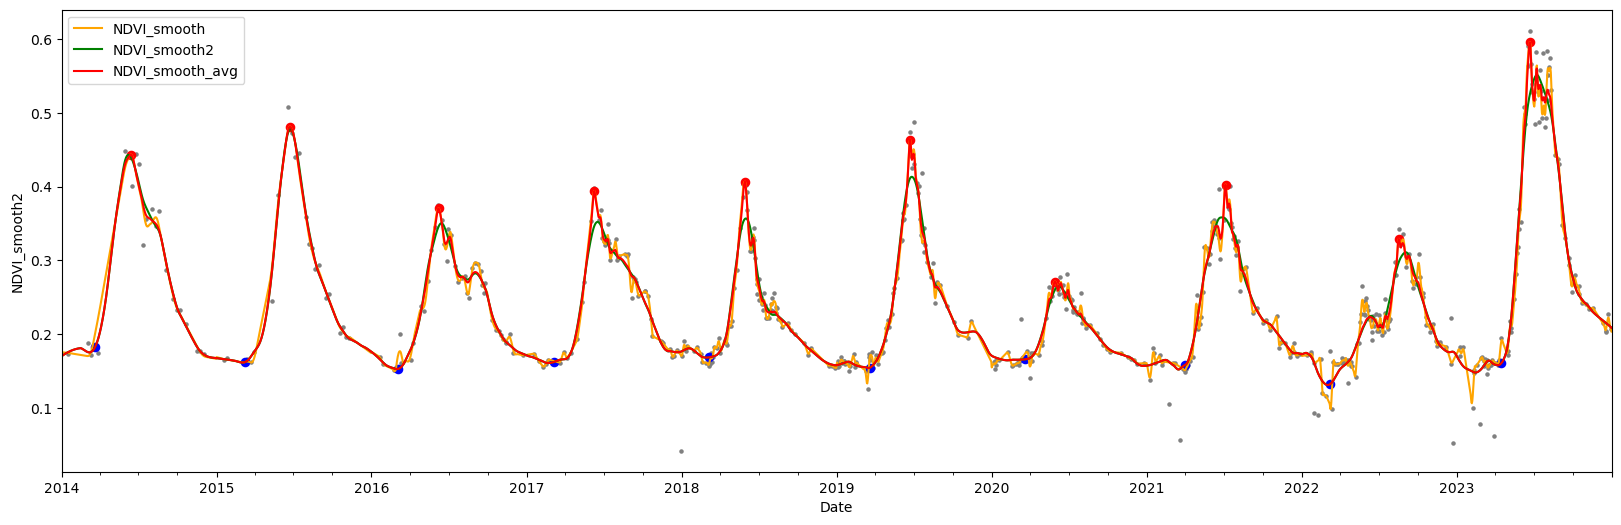

In [35]:
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = 'Northeast'
ndvi_peak_vals = df_ndvi[df_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['NDVI_smooth'].iloc[np.argmax(x['NDVI_smooth'])])
ndvi_peak_dates = df_ndvi[df_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['Date'].iloc[np.argmax(x['NDVI_smooth'])])
df_ndvi[df_ndvi['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=ax1, c='grey', s=5)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth2', c='green', ax=ax1)
ax1.scatter(ndvi_peak_dates.values, ndvi_peak_vals.values, c='red', s=35)
df_sos[df_sos['Id'] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth2',  ax=ax1, c='blue', s=35)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth_avg', ax=ax1, c='red')

In [36]:
df_ndvi.to_csv(outPATH_ndvi, index=False)

In [37]:
df_sos.drop(columns=['Date']).to_csv(outPATH_sos, index=False)